# Analyzing NYC High School Data

In this project, we are looking to analyze NYC High School Data, available from [NYC Open Data](https://data.cityofnewyork.us/browse?category=Education), to determine correlation between many demographic variables and average SAT Scores.

These variables will include:

 - Location (by Borough)
 - Percentage of Student Body by Race (Asian, Black, White, Hispanic)
 - Safety, Communication, and Academic Expectations (broken into Student Response, Parent Response, Admin Response, and Total Response)


## Reading the Data

In [1]:
###Importing Necessary Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 

###Adding Data Files to list
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

###Setting up a Dictionary to hold all DataFrames
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Reading the Surveys

In [2]:
###Ensuring Proper Encoding and Delimiters on survey responses
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Adding DBN columns

In [3]:
###Ensuring each school has a unique DBN
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Converting columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

###Identifying and Pulling longitutde and latitude for each school

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

###Creating unique longitude and latitude columns
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing datasets

In [5]:
###Filtering to only include High School, General Education
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

###Averaging class sizes for each individual school under one DBN
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

###Filtering by latest available data
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Converting AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

###Using pd.to_numeric()

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining the datasets

In [7]:
###Combining allows us to not keep the data in a dictionary to be called

combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

###Using inner merge to ensure all remaining rows have all relevant values
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

###Filling the null values based on whether or not there is an existing number
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Adding a school district column for mapping

In [8]:
###The first two characters of a DBN code refer to the district of the school

def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding correlations

In [9]:
###Specifying sat_score as the variable to be correlated against

correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
###Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

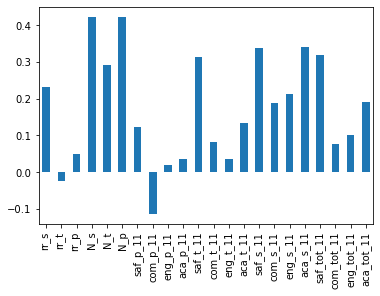

In [11]:
###Creating a Bar Shart of Correlation of Variables with sat_score

combined.corr()['sat_score'][survey_fields].plot.bar()

From the bar chart of correlations above, there are a few interesting phenomena:

 - The Academic Expectations of the students (_aca_tot_11_) had a positive correlation with SAT Scores, which can likely be due to increased rigor of a school leading to better prepared students. The correlation was even stronger when comparing only student responses (_aca_s_11_)
 
 
 - While Engagement (_eng_tot_11_) was also positively correlated, it was not as strong a correlation.
 
 
 - The lone notable negative correlation is the Communication Score of parent responses.
 
 
 - Finally, the Safety and Respect scores of both sutdent responses and total responses were strongly positively correlated as well, as school where students are likely to be safer are better environments for studying. Additionally, there is likely correlation between the safety of a school and the financial well-being of a student and the resources available to them.
 
Below, we will be digging further into the Safety and Respect correlation.

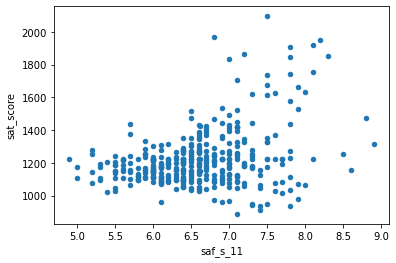

In [12]:
###Creating a Scatter Plot between Safety (according to Students) and SAT Score

combined.plot.scatter(x='saf_s_11', y='sat_score')

As expected due to the bar graph, there is a definite positive correlation between the students' perceived safety and SAT scores. As can be seen there isn't a major positive correlation between safety values of 5 or less to 7, but from 7-9 the SAT scores become increased varied in a positive fashion. No school with a safety score lower than 6.5 has an average SAT score higher than roughly 1500.

## Computing Safety Scores by Borough

In [13]:
boros = combined.groupby("boro").agg(np.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


All the boroughs have relatively similar safety values, with Manhattan being the safest, and Brooklyn being the lowest.

## Exploring Race and SAT Scores

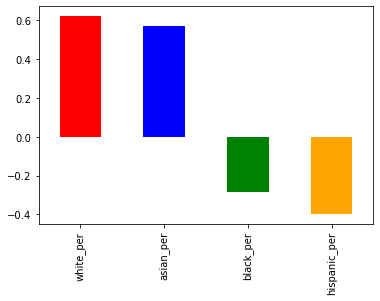

In [14]:
###Creating a Bar Plot

race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_cols].plot.bar(color=['red', 'blue', 'green', 'orange'])

As seen above, there are positive correlations between the percentage of white and asian students and SAT scores, and negative correlations between the percentage of black and hispanic students and SAT scores.

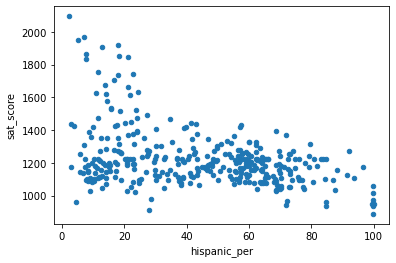

In [15]:
###Explring schools with low SAT scores and high percentage of Hispanic students

combined.plot.scatter(x='hispanic_per', y='sat_score')

There is a definite negative correlation here. It seems that once a school hits 35-40% hispanic population the average SAT score does not peak above 1500.

In [16]:
###Pulling all school with hispanic percentage above 95% in order to scrape information from the web###

high_hisp_per = combined[combined['hispanic_per'] > 95]

high_hisp_per[['SCHOOL NAME', 'sat_score','hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0


All of the above schools have one major factor in common: the coursework is primarily carried out in Spanish. The potential lack of English ability among the students would certainly explain the lower than average SAT scores.

In [17]:
###Pulling all schools with hispanic percentage lower than 10% and SAT above 1800

high_sat_hisp = combined[combined['hispanic_per'] < 10]

high_sat_hisp = high_sat_hisp[high_sat_hisp['sat_score'] > 1800]

high_sat_hisp

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0.0,0.0,0.0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0.0,0.0,0.0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


The 5 schools above are considered among NYC's "Specialized High Schools". In order to gain admission to these schools students must pass standardized tests, as such it would stand to reason that they would have lower hispanic percentages (due to similar correlations as above) and higher SAT scores.

## Exploring Gender and SAT Scores

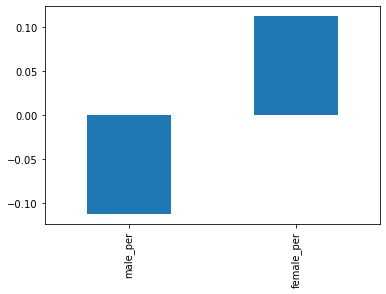

In [18]:
###Making a bar plot of correlation between gender columns and SAT score###

combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

There is a positive correlation between percentage of females and SAT score, that is negative for males.

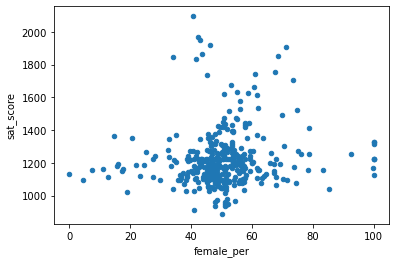

In [19]:
###Investigating high SAT scores and high percentage of females

combined.plot.scatter(x='female_per', y='sat_score')

As determined by the bar plot above, there is a positive correlation, however it is incredibly weak, as a large number of schools have SAT scores within the 1000-1400 range regardless of percentage of female students.

In [20]:
###Pulling all schools with female percenage over 60% and SAT score over 1700

high_female_sat = combined[combined['female_per'] > 60]
high_female_sat = high_female_sat[high_female_sat['sat_score'] > 1700]
high_female_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


Similar to the group of schools above, these schools all require admissions exams. This increases the liklihood of the student body being made up of students who are likely to do well on the SAT.

## Exploring AP Class Enrollment and SAT Scores

0.05717081390766967

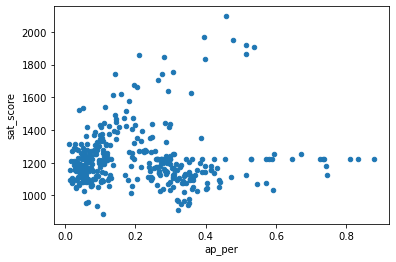

In [21]:
###Calculating AP Enrollment Percentage
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score')

combined.corr()['ap_per']['sat_score']

The scatter plot, as well as the correlation coefficient calculated, seem to indicate a very weak positive correlation between AP enrollment and SAT scores. This is relatively unexpected, however one potential cause is that a large majority of the schools simply don't have a AP percentage enrollment high enough to make for interesting results.

Lastly, we will be looking at correlation between class size and SAT scores.

## Exploring Class Size and SAT Scores

0.3810143308095523

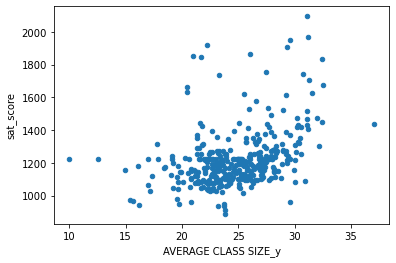

In [36]:
###Merging the Class Size dataset with the larger combined set

combined_with_size = pd.merge(combined, class_size, on='DBN', how='inner')

combined_with_size.head()

combined_with_size.plot.scatter(x='AVERAGE CLASS SIZE_y', y='sat_score')

combined_with_size.corr()['AVERAGE CLASS SIZE_y']['sat_score']

Perhaps unexpectedly, there is a fairly strong positive correlation between class size and SAT score. This could be because schools with smaller class sizes have less resources than schools that can support many students.

The plot above shows that SAT scores from 1000-1600 are common among schools regardless of class size, but it's not until average size is 20 students where higher averages, up to 2000, can be seen.

## Conclusion

#### As seen through the analysis, there are indeed factors that tended to correlate to higher average SAT scores:

 - Higher percent of student population being Asian or White
 
 - Higher feelings of safety among the students
 
 - Higher average class size, though it is likely there is an upper limit to when this is true.
 
#### Other variables did not have as major of a correlation in either direction:

 - The percentage of students who are males and females does not correlate significantly in either direction.
 
 - The percentage of students enrolled in AP Classes does not correlate either.
 
While female population did have a weak positive correlation, and male population had a weak negative correlation, both groups of schools have individual cases of no correlation at all, with the largest correlation only being r=.1 and -.1.

While the percentage of students enrolled in AP classes likely correlated with the academic rigor and expectation of the school itself, it is not a direct measure of student intelligence. Students in certain schools may be in AP classes when they may not reasonably be able to pass the AP exams, and in others the students may be intillgent enough to perform well on the SAT but their school doesn't offer AP classes.
 
#### Finally, some variables correlated to lower average SAT scores:

 - The percentage of student population being Black or Hispanic has correlated to lower SAT scores.

It is not fair, however, to say that this is due to lower intelligence among these students. It is more likely that the schools these students attend are more limited in their resources and capability, and depending on location may not be as safe, or have the same academic expectations for their students. As we saw above, many schools with high percentages of Hispanic students were taught almost entirely in Spanish, leading to the students perhaps not being as well prepared for the English-based SAT.